In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from torch.utils.data import Dataset, DataLoader

from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import copy
import random
import time
from torch.utils.data import random_split


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_images = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTrainImages 60k x 784.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTrainLabel 60k x 1.csv")
test_images = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTestImages 10k x 784.csv")
test_labels = pd.read_csv("/content/drive/MyDrive/machine learning project/machine/csvTestLabel 10k x 1.csv")

# add the lables of the dataset
train_images['label'] = train_labels
test_images['label'] = test_labels

print(train_images.shape)
print(test_images.shape)
print(train_images.head())


(59999, 785)
(9999, 785)
   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.487  0.488  0.489  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.490  0.491  0.492  0.493  0.494  0.495  label  
0      0      0      0      0      0      0      1  
1      0      0      0      0      0      0      2  
2      0      0      0      0      0      0      3  
3      0      0      0      0      0      0      4  
4      0      0      0      0      0      0      5  

[5 rows x 785 columns]


In [ ]:
class ImageDataset(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index, self.data.columns != 'label'].values.astype(np.uint8).reshape(28, 28)
        label = self.data.iloc[index, -1]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
test_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

In [ ]:
train_dataset =ImageDataset(train_images,train_transform)
test_dataset=ImageDataset(test_images,test_transform)

train_idx,val_idx=random_split(train_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))
train_list=[train_dataset[i] for i in train_idx.indices]
val_list=[train_dataset[i] for i in val_idx.indices]
image , label = train_dataset.__getitem__(32)
print(type(image))
print(type(label))
image.size()

<class 'torch.Tensor'>
<class 'numpy.int64'>


torch.Size([1, 28, 28])

In [ ]:
#visualization function
def visualize(n,images,labels):
  rows = int(np.sqrt(n))
  cols = int(np.sqrt(n))
  fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols,2*rows))
  for i in range(rows*cols):
    ax = axes[i//cols, i%rows]
    ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'gray')
    ax.set_title('Label: {}'.format(labels[i]))
    ax.axis('off')

In [ ]:
N_IMAGES = 25
train_images = [image for image, label in [train_dataset[i] for i in range(N_IMAGES)]]
train_labels = [label for image, label in [train_dataset[i] for i in range(N_IMAGES)]]

test_images = [image for image, label in [test_dataset[i] for i in range(N_IMAGES)]]
test_labels = [label for image, label in [test_dataset[i] for i in range(N_IMAGES)]]

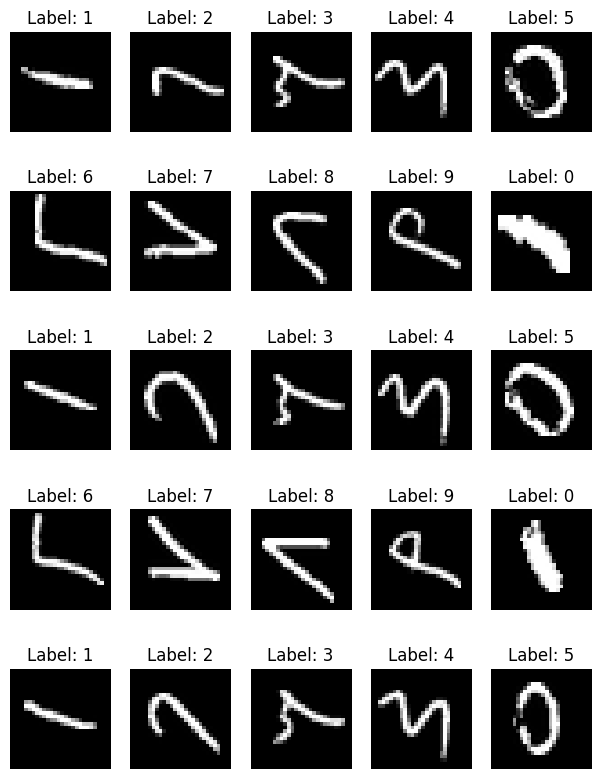

In [ ]:
#visualize a small batch of the training set
visualize(N_IMAGES,train_images,train_labels)

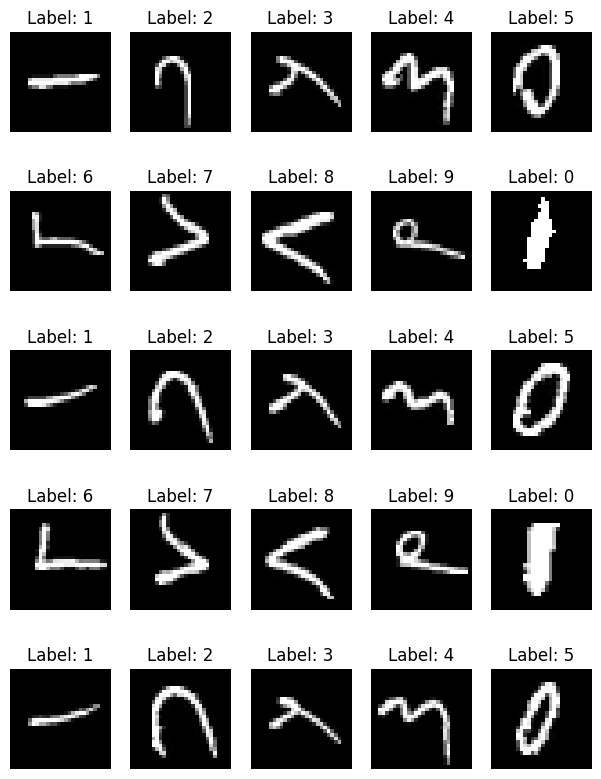

In [ ]:
#visualize a small batch of the training set
visualize(N_IMAGES,test_images,test_labels)

In [ ]:
train_loader= torch.utils.data.DataLoader(train_list ,shuffle = True, batch_size = 128 )
val_loader=torch.utils.data.DataLoader(val_list ,shuffle = True, batch_size = 128  )
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
    def forward(self, x):
        #x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        #x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))
        #h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))
        #h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        #y_pred = [batch size, output dim]
        return y_pred, h_2

In [ ]:
# We'll define our model by creating an instance of it and setting the correct input and output dimensions.
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 222,360 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
# The final step before training is to define a small function to tell us how long an epoch took.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 20
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, device)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.272 | Train Acc: 92.43%
	 Val. Loss: 0.172 |  Val. Acc: 94.96%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.109 | Train Acc: 96.80%
	 Val. Loss: 0.094 |  Val. Acc: 97.40%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.085 | Train Acc: 97.49%
	 Val. Loss: 0.083 |  Val. Acc: 97.69%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.069 | Train Acc: 98.01%
	 Val. Loss: 0.076 |  Val. Acc: 97.70%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.061 | Train Acc: 98.10%
	 Val. Loss: 0.071 |  Val. Acc: 98.08%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.051 | Train Acc: 98.45%
	 Val. Loss: 0.057 |  Val. Acc: 98.38%
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.047 | Train Acc: 98.51%
	 Val. Loss: 0.061 |  Val. Acc: 98.31%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.041 | Train Acc: 98.70%
	 Val. Loss: 0.053 |  Val. Acc: 98.47%
Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 0.039 | Train Acc: 98.81%
	 Val. Loss: 0.061 |  Val. Acc: 98.41%
Epoch: 10 | Epoch Time: 0m 2

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

In [ ]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.084 | Test Acc: 98.00%


In [ ]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs
# We can then get these predictions and, by taking the index of the highest predicted probability, get the predicted labels.
images, labels, probs = get_predictions(model, val_loader, device)
pred_labels = torch.argmax(probs, 1)
# Next, for each of our examples, we can check if our predicted label matches our actual label.
corrects = torch.eq(labels, pred_labels)
print(corrects)

tensor([True, True, True,  ..., True, True, True])


In [ ]:
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

In [ ]:
correct_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if  correct:
        correct_examples.append((image, label, prob))

In [ ]:
def plot_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

In [ ]:
def plot_correct(correct, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = correct[i]
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {correct_label} ({correct_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

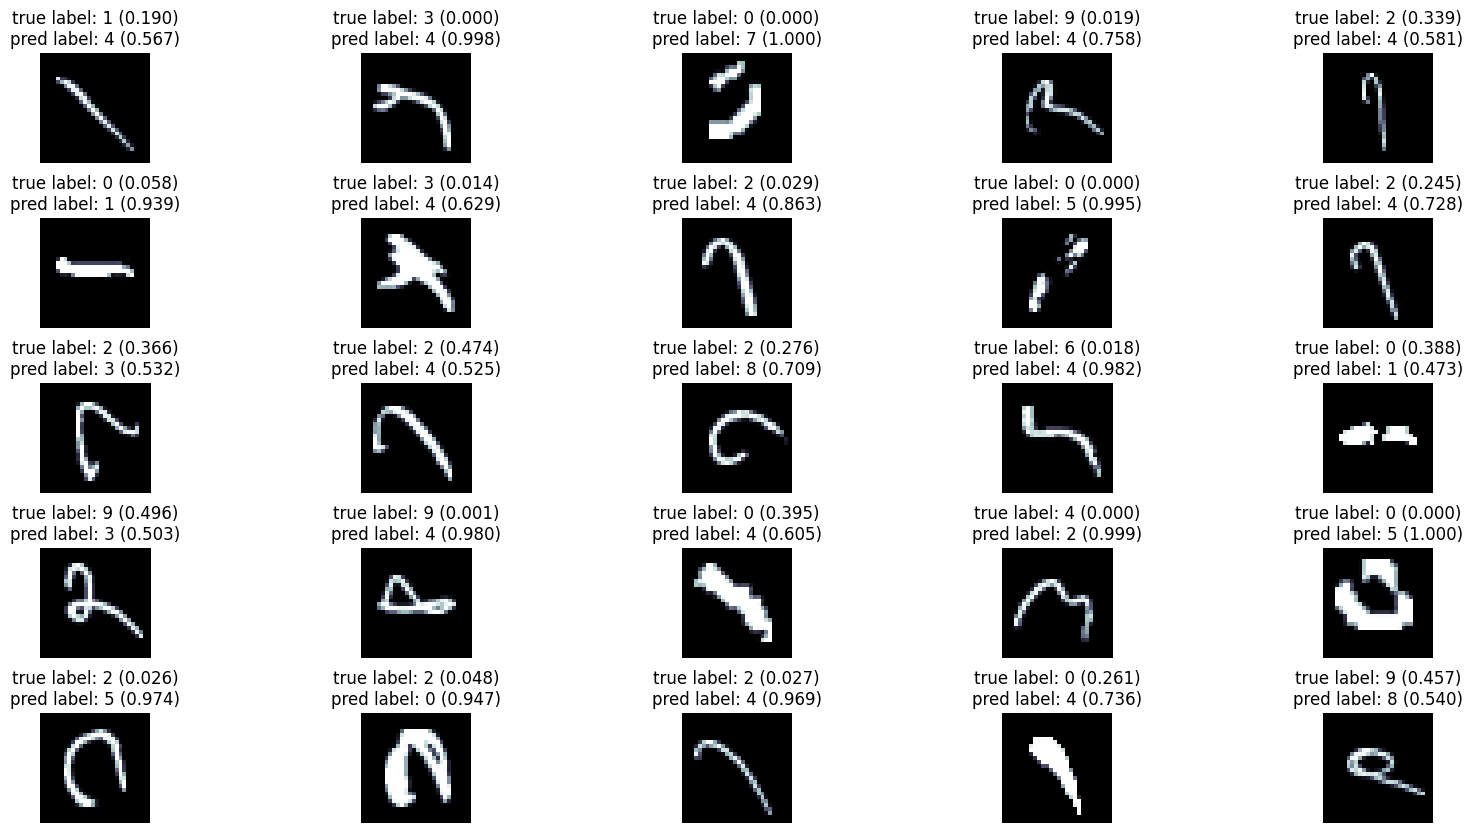

In [ ]:
N_IMAGES = 25
plot_incorrect(incorrect_examples, N_IMAGES)

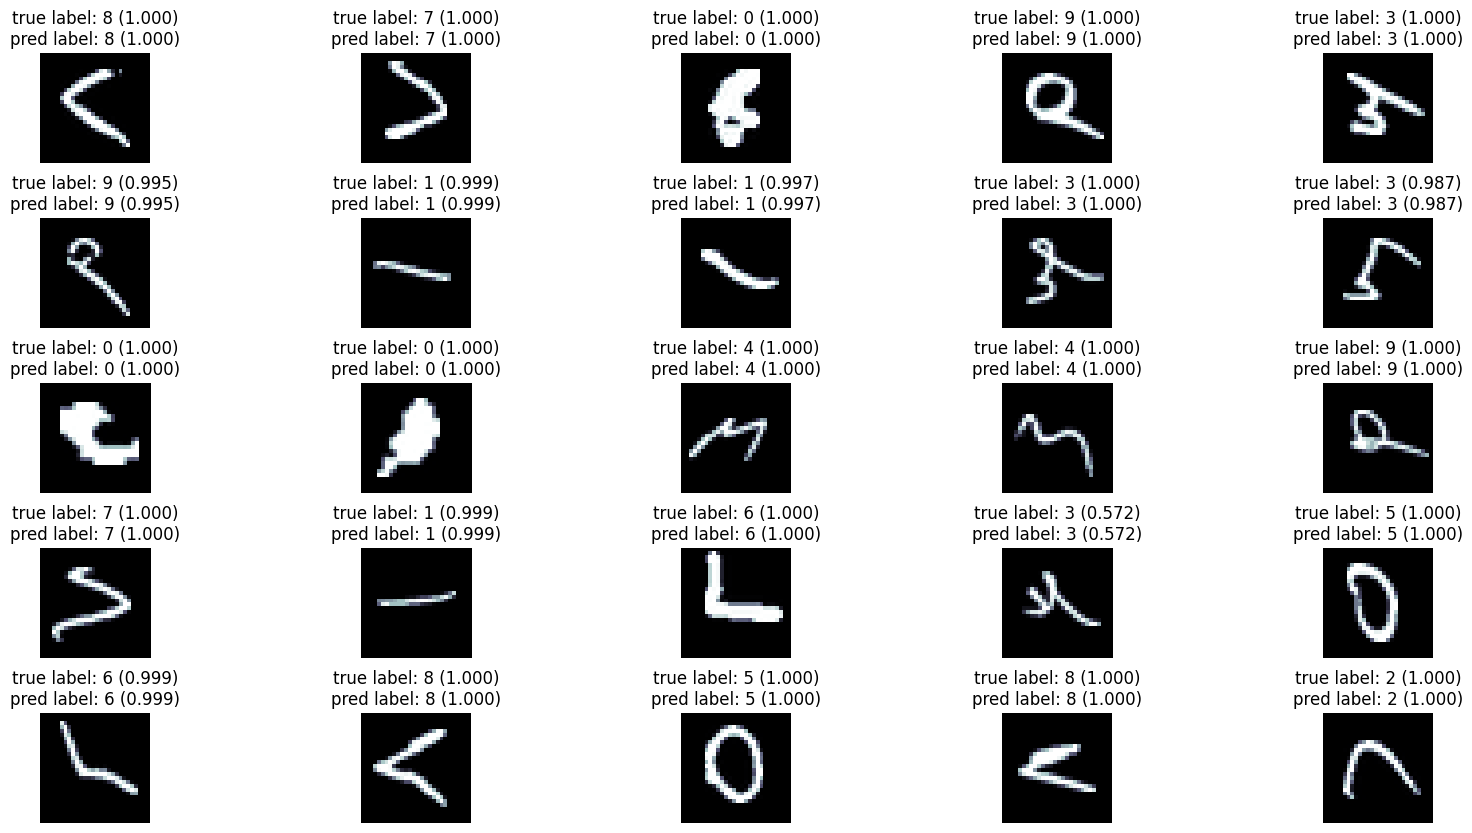

In [ ]:
N_IMAGES = 25
plot_correct(correct_examples, N_IMAGES)